<h1>Imports</h1>

In [56]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip , RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0, EfficientNetV2B3
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from collections import Counter



<h1> Load Dataset </h1>

In [57]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)

BATCH_SIZE = 32 
IMAGE_SIZE = (160, 160)

image_paths_training = []
labels = []

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)


Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


<h1> Visualising Dataset</h1>

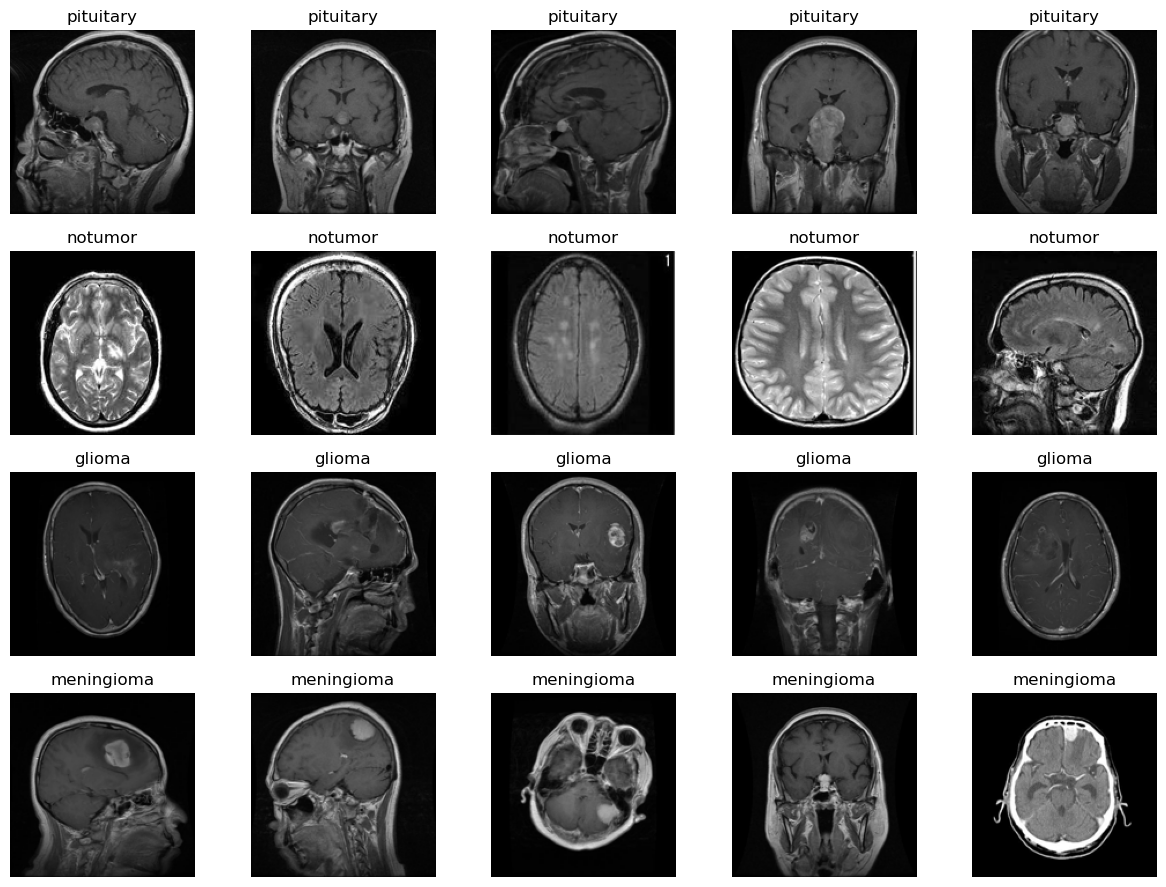

In [58]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

<h1> Model </h1>

<h3> EfficientNetV2B0 </h3>

In [59]:
from keras.regularizers import l2
from keras.layers import Input

def create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max', input_tensor=input_tensor)

    out_relu = EfficientNetV2B0_model.layers[-1]
    x = Dropout(dropout_rate)(out_relu.output)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h3>MobileNetV2</h1>

In [60]:
def MobileNetV2_create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    MobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, pooling='max', input_tensor=input_tensor)

    out_relu = MobileNetV2_model.layers[-1]
    x = Dropout(dropout_rate)(out_relu.output)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1>K-cross validation</h1>

In [63]:

skf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=123)

models_and_scores = []
class_names = []

MobileNetV2_models_and_scores = []

test_generator = None

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
    
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})

    print("Train class distribution: ", train_df['label'].value_counts())


    # train_datagen = IDG(
    #             shear_range= 0.3,  
    #             zoom_range = 0.4,  
    #             width_shift_range = 0.3,  
    #             height_shift_range = 0.3,
    #             horizontal_flip=True,
    #             rotation_range=20,
    #             fill_mode = "nearest")
    
    train_datagen = IDG()
    
    train_datagen_rescaled = IDG(
                rescale=1./255,
                shear_range= 0.3,  
                zoom_range = 0.4,  
                width_shift_range = 0.3,  
                height_shift_range = 0.3,
                horizontal_flip=True,
                fill_mode = "nearest")
    

    val_datagen = IDG()

    val_datagen_rescaled = IDG(
                rescale=1./255,)
    

    test_datagen = IDG()

    test_datagen_rescaled = IDG(
                rescale=1./255,
    )

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)

    train_generator_rescaled = train_datagen_rescaled.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    val_generator_rescaled = val_datagen_rescaled.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)
    test_generator_rescaled= test_datagen_rescaled.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb', batch_size = BATCH_SIZE)

    class_names = list(test_generator.class_indices)
    
    model = create_model()
    modelM = MobileNetV2_create_model()  

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    model.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weights, verbose = 1)
    modelM.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weights, verbose = 1)

    score = model.evaluate(test_generator)
    MobileNetV2_score = modelM.evaluate(test_generator)
    print(f"EfficientNetV2B0 score: {score}")
    print(f"MobileNetV2 score: {MobileNetV2_score}")

    models_and_scores.append((model, score))
    MobileNetV2_models_and_scores.append((modelM, MobileNetV2_score))

best_model, best_score = max(models_and_scores, key=lambda x: x[1][1])
best_MobileNetV2_model, best_MobileNetV2_score = max(MobileNetV2_models_and_scores, key=lambda x: x[1][1])

Train class distribution:  label
notumor       1276
pituitary     1165
meningioma    1071
glioma        1057
Name: count, dtype: int64
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Epoch 1/15


2024-03-26 12:26:43.850302: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_350/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 25s 68ms/step - loss: 1.7708 - accuracy: 0.4067 - val_loss: 0.6573 - val_accuracy: 0.7655
Epoch 2/15
143/143 [==============================] - 9s 59ms/step - loss: 1.1022 - accuracy: 0.6076 - val_loss: 0.4200 - val_accuracy: 0.8626
Epoch 3/15
143/143 [==============================] - 9s 61ms/step - loss: 0.7583 - accuracy: 0.7428 - val_loss: 0.3565 - val_accuracy: 0.8766
Epoch 4/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5644 - accuracy: 0.8063 - val_loss: 0.3134 - val_accuracy: 0.8889
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5047 - accuracy: 0.8310 - val_loss: 0.2683 - val_accuracy: 0.9003
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4291 - accuracy: 0.8551 - val_loss: 0.2467 - val_accuracy: 0.9081
Epoch 7/15
143/143 [==============================] - 9s 60ms/step - loss: 0.3691 - accuracy: 0.8801 - val_loss: 0.2139 - val_accuracy: 0.9160
Epoch 8/1

2024-03-26 12:31:14.868857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_352/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 26s 67ms/step - loss: 1.7420 - accuracy: 0.4080 - val_loss: 0.7194 - val_accuracy: 0.7262
Epoch 2/15
143/143 [==============================] - 9s 60ms/step - loss: 1.1455 - accuracy: 0.5942 - val_loss: 0.4810 - val_accuracy: 0.8381
Epoch 3/15
143/143 [==============================] - 9s 60ms/step - loss: 0.8582 - accuracy: 0.6977 - val_loss: 0.3691 - val_accuracy: 0.8723
Epoch 4/15
143/143 [==============================] - 9s 61ms/step - loss: 0.6864 - accuracy: 0.7676 - val_loss: 0.3180 - val_accuracy: 0.8924
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5458 - accuracy: 0.8087 - val_loss: 0.2924 - val_accuracy: 0.8950
Epoch 6/15
143/143 [==============================] - 9s 61ms/step - loss: 0.4769 - accuracy: 0.8365 - val_loss: 0.2672 - val_accuracy: 0.9046
Epoch 7/15
143/143 [==============================] - 9s 61ms/step - loss: 0.4226 - accuracy: 0.8520 - val_loss: 0.2355 - val_accuracy: 0.9160
Epoch 8/1

2024-03-26 12:35:46.991733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_354/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 24s 66ms/step - loss: 1.7686 - accuracy: 0.4278 - val_loss: 0.6944 - val_accuracy: 0.7452
Epoch 2/15
143/143 [==============================] - 8s 58ms/step - loss: 1.1219 - accuracy: 0.6219 - val_loss: 0.4484 - val_accuracy: 0.8476
Epoch 3/15
143/143 [==============================] - 8s 59ms/step - loss: 0.8577 - accuracy: 0.6963 - val_loss: 0.3402 - val_accuracy: 0.8940
Epoch 4/15
143/143 [==============================] - 8s 59ms/step - loss: 0.6922 - accuracy: 0.7641 - val_loss: 0.3008 - val_accuracy: 0.9046
Epoch 5/15
143/143 [==============================] - 9s 59ms/step - loss: 0.5380 - accuracy: 0.8171 - val_loss: 0.2476 - val_accuracy: 0.9072
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4836 - accuracy: 0.8330 - val_loss: 0.2151 - val_accuracy: 0.9247
Epoch 7/15
143/143 [==============================] - 9s 59ms/step - loss: 0.4172 - accuracy: 0.8551 - val_loss: 0.1985 - val_accuracy: 0.9273
Epoch 8/1

2024-03-26 12:40:15.219131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_356/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 24s 67ms/step - loss: 1.7352 - accuracy: 0.3753 - val_loss: 0.5914 - val_accuracy: 0.7977
Epoch 2/15
143/143 [==============================] - 9s 60ms/step - loss: 1.0585 - accuracy: 0.6059 - val_loss: 0.4118 - val_accuracy: 0.8485
Epoch 3/15
143/143 [==============================] - 9s 60ms/step - loss: 0.7841 - accuracy: 0.7302 - val_loss: 0.3363 - val_accuracy: 0.8792
Epoch 4/15
143/143 [==============================] - 9s 60ms/step - loss: 0.6328 - accuracy: 0.7849 - val_loss: 0.3014 - val_accuracy: 0.8923
Epoch 5/15
143/143 [==============================] - 9s 60ms/step - loss: 0.5137 - accuracy: 0.8214 - val_loss: 0.2714 - val_accuracy: 0.9002
Epoch 6/15
143/143 [==============================] - 9s 60ms/step - loss: 0.4488 - accuracy: 0.8510 - val_loss: 0.2490 - val_accuracy: 0.9159
Epoch 7/15
143/143 [==============================] - 9s 61ms/step - loss: 0.4174 - accuracy: 0.8615 - val_loss: 0.2107 - val_accuracy: 0.9229
Epoch 8/1

2024-03-26 12:44:47.271437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_358/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 26s 67ms/step - loss: 1.7447 - accuracy: 0.3910 - val_loss: 0.6516 - val_accuracy: 0.7706
Epoch 2/15
143/143 [==============================] - 9s 60ms/step - loss: 1.0842 - accuracy: 0.6085 - val_loss: 0.4081 - val_accuracy: 0.8538
Epoch 3/15
143/143 [==============================] - 8s 59ms/step - loss: 0.8366 - accuracy: 0.7138 - val_loss: 0.3084 - val_accuracy: 0.8975
Epoch 4/15
143/143 [==============================] - 9s 60ms/step - loss: 0.6308 - accuracy: 0.7803 - val_loss: 0.2512 - val_accuracy: 0.9089
Epoch 5/15
143/143 [==============================] - 9s 63ms/step - loss: 0.5409 - accuracy: 0.8173 - val_loss: 0.2159 - val_accuracy: 0.9212
Epoch 6/15
143/143 [==============================] - 9s 62ms/step - loss: 0.4658 - accuracy: 0.8394 - val_loss: 0.1849 - val_accuracy: 0.9317
Epoch 7/15
143/143 [==============================] - 9s 62ms/step - loss: 0.3781 - accuracy: 0.8648 - val_loss: 0.1677 - val_accuracy: 0.9457
Epoch 8/1

<h1> Grad-Cam</h1>

1/1 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000


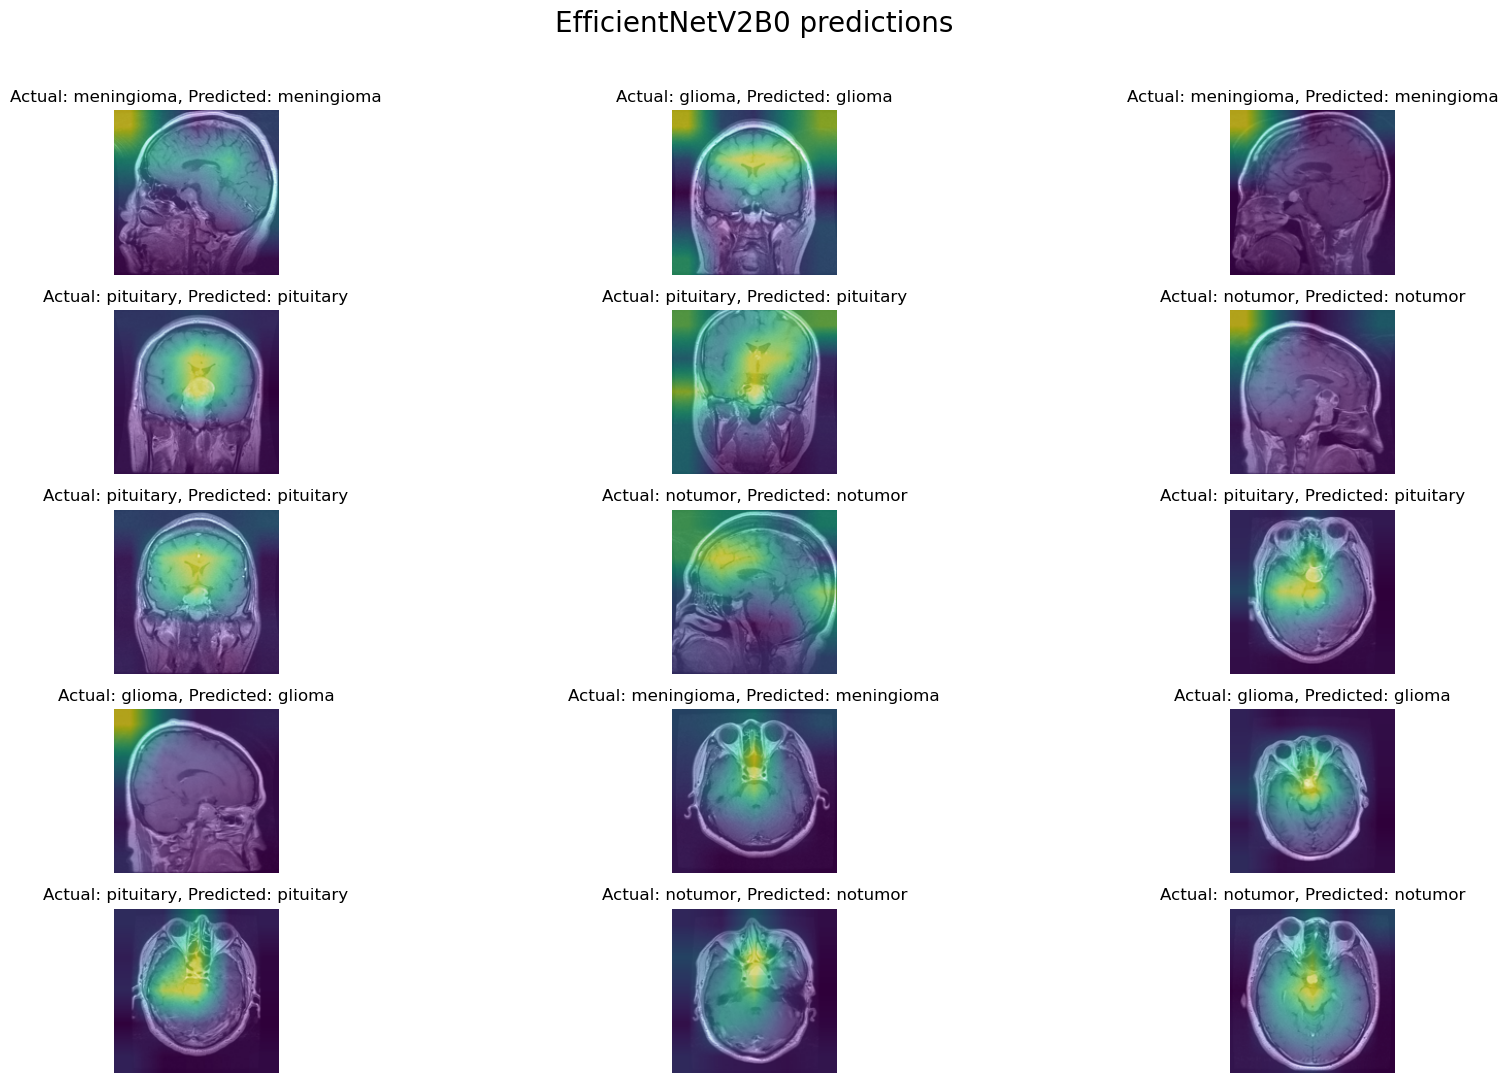

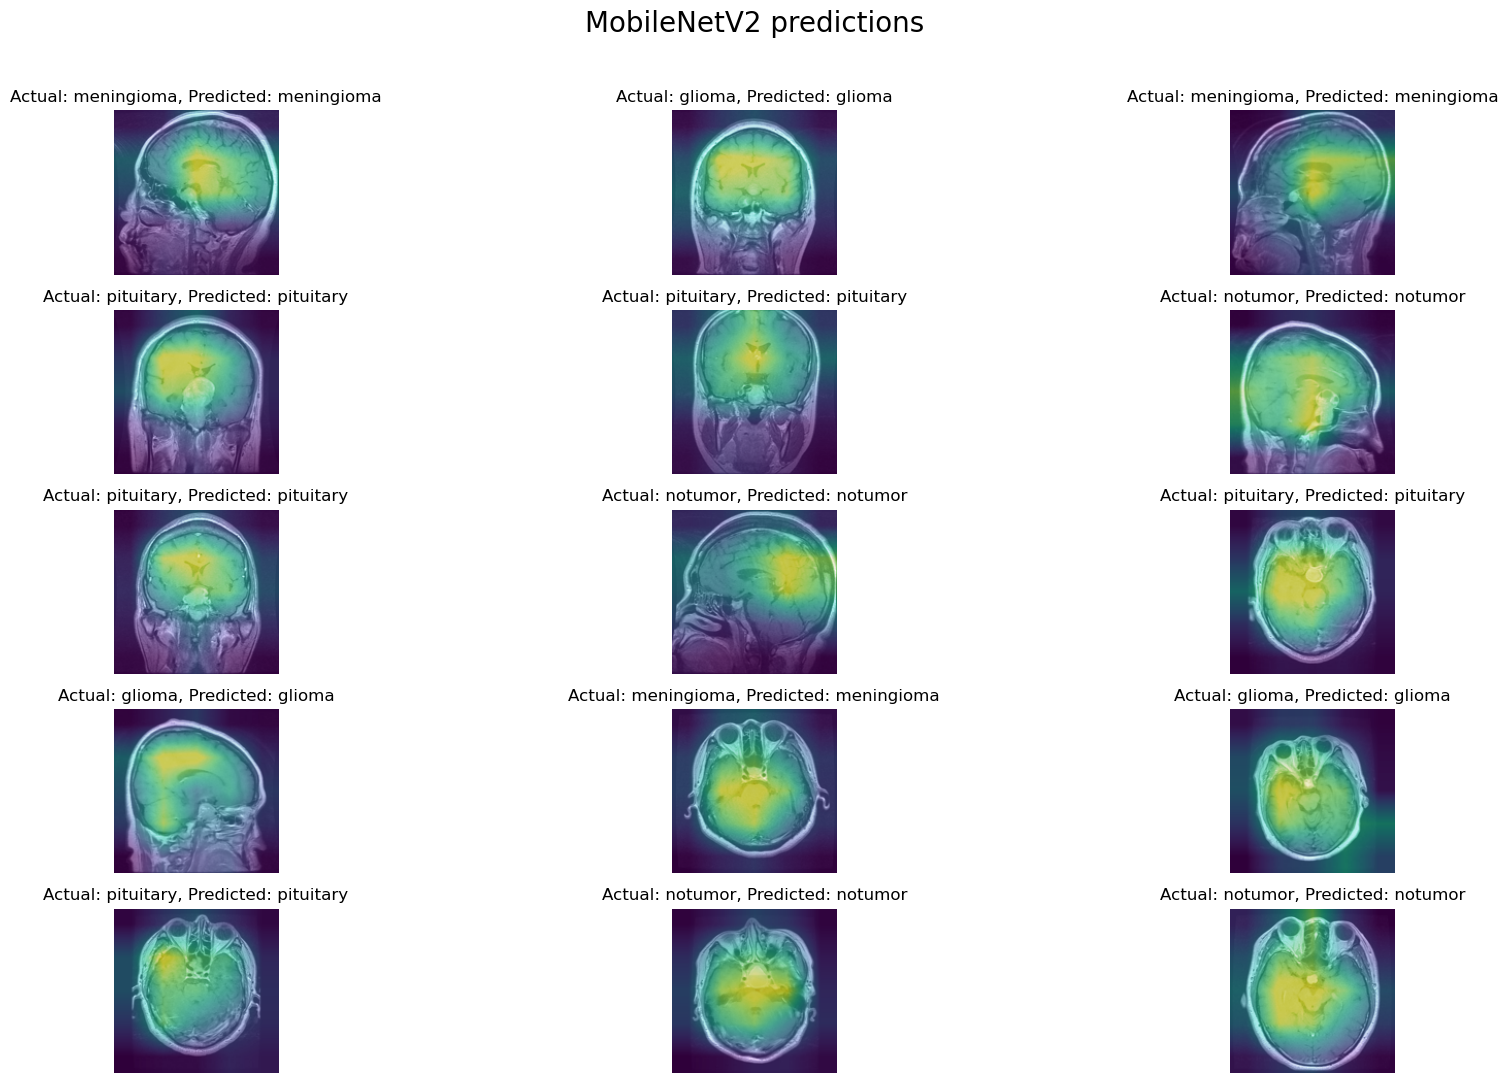

In [71]:
from tf_explain.core.grad_cam import GradCAM as GradCAME

images_list, labels_list = [], []

for _ in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    images_list.extend(images_batch)
    labels_list.extend(labels_batch)


indices = np.random.choice(len(images_list), size=15, replace=False)


random_images = np.array([images_list[i] for i in indices])
random_labels = [labels_list[i] for i in indices]


predictions = best_model.predict(random_images)
MobileNetV2_predictions = best_MobileNetV2_model.predict(random_images)


evaluations = best_model.evaluate(random_images, np.array(random_labels))
MobileNetV2_evaluations = best_MobileNetV2_model.evaluate(random_images, np.array(random_labels))


predicted_classes = np.argmax(predictions, axis=1)
MobileNetV2_predicted_classes = np.argmax(MobileNetV2_predictions, axis=1)

actual_classes = [np.argmax(label) for label in random_labels]

gradcam = GradcamPlusPlus(best_model)
MobileNetV2_gradcam = GradcamPlusPlus(best_MobileNetV2_model)

explainer = GradCAME()

plt.figure(figsize=(20, 11))
plt.suptitle("EfficientNetV2B0 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    grid = explainer.explain(([image], None), best_model, predicted_class)

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(grid, cmap='hot', alpha=0.7)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.figure(figsize=(20, 11))
plt.suptitle("MobileNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, MobileNetV2_predicted_classes)):
    grid = explainer.explain(([image], None), best_MobileNetV2_model, predicted_class)

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    plt.imshow(grid, cmap='hot', alpha=0.7)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h1>Lime</h1>

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 20/300 [00:00<00:01, 167.63it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 50/300 [00:00<00:01, 207.77it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 80/300 [00:00<00:00, 221.91it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 110/300 [00:00<00:00, 227.51it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 232.57it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 237.51it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 237.38it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 234.85it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 254/300 [00:01<00:00, 235.94it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 231.09it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 300/300 [00:01<00:00, 229.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 225.72it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 235.95it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 240.59it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 241.19it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 243.78it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 245.51it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 241.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 239.65it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 240.60it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 240.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 221.05it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 233.90it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 238.61it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 243.86it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 150/300 [00:00<00:00, 242.56it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████▊    | 175/300 [00:00<00:00, 244.12it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 236.59it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 243.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 244.24it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 242.01it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 241.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 233.76it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 240.23it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 239.71it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 118/300 [00:00<00:00, 253.03it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 144/300 [00:00<00:00, 234.42it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 220.81it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 227.78it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 231.40it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 229.42it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 284/300 [00:01<00:00, 230.68it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 228.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 238.28it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 56/300 [00:00<00:00, 248.85it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 81/300 [00:00<00:00, 232.61it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 110/300 [00:00<00:00, 238.15it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 240.96it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 236.79it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 235.98it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 238.03it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 242.58it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 285/300 [00:01<00:00, 238.86it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 235.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 245.49it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:01, 235.93it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 234.76it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 237.53it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 236.16it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 238.94it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 210/300 [00:00<00:00, 232.86it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:01<00:00, 235.49it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 233.82it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 235.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 238.69it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 246.27it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 250.21it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 252.45it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 150/300 [00:00<00:00, 251.40it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 244.92it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 246.92it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 249.68it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.65it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 247.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 236.01it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 231.15it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 235.19it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 114/300 [00:00<00:00, 234.92it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 229.55it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 238.02it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 244.62it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 237.88it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 241.07it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 242.86it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 239.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 30/300 [00:00<00:01, 210.63it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 225.57it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 237.06it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 244.10it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 244.44it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 248.12it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 249.18it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:01<00:00, 239.39it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 265/300 [00:01<00:00, 241.52it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 225.97it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 235.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 234.68it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 246.41it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 237.56it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 242.28it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 241.43it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 236.62it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 236.21it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 234/300 [00:00<00:00, 236.19it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 224.44it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 224.56it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 232.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 242.21it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:01, 236.33it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 86/300 [00:00<00:00, 245.54it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 111/300 [00:00<00:00, 226.65it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 227.94it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 236.25it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 231.23it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 231.36it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 234.12it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 235.37it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 233.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 243.58it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 244.18it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 240.73it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 242.03it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 246.28it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 249.76it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 242.11it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:00<00:00, 236.69it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 238.20it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 241.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 226.15it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:01, 227.46it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 226.83it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 230.24it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 144/300 [00:00<00:00, 230.26it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 217.88it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 221.24it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 224.17it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 231.82it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 237.14it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 230.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 238.98it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 227.47it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 90/300 [00:00<00:00, 222.73it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 113/300 [00:00<00:00, 220.11it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 211.76it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 213.96it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 221.69it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 225.89it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 253/300 [00:01<00:00, 225.19it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 276/300 [00:01<00:00, 223.00it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 218.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 241.72it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:00, 240.36it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 238.30it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 233.96it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 227.00it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 173/300 [00:00<00:00, 223.56it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 216.28it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 221.73it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 225.01it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 286/300 [00:01<00:00, 233.83it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 300/300 [00:01<00:00, 224.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


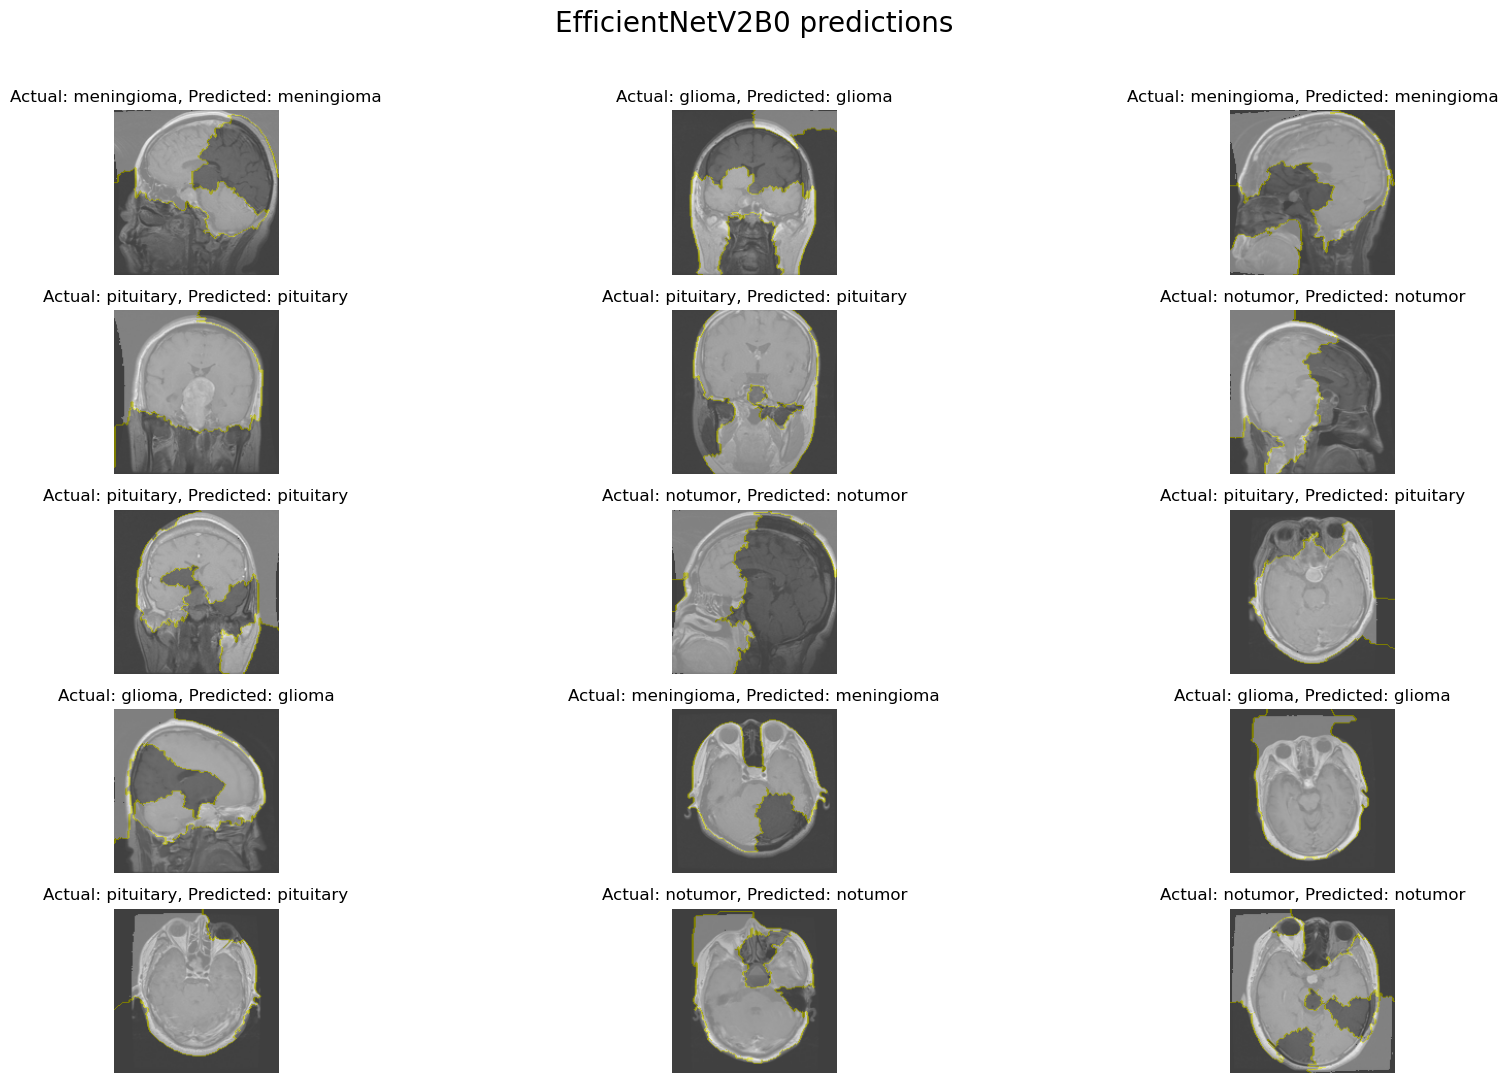

Text(0.5, 0.98, 'MobileNetV2 predictions')

<Figure size 2000x1100 with 0 Axes>

In [74]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    return best_model.predict(images)


plt.figure(figsize=(20, 11))
plt.suptitle("EfficientNetV2B0 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, predicted_classes)):
    # Explain a prediction
    explanation = explainer.explain_instance(image, predict_fn, top_labels=4, num_samples=300)

    # Get the mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    # Overlay the LIME explanation
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




<h3> Lime MobileV</h3>

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 235.54it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 245.66it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 232.79it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 246.13it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 251.60it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 257.39it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 257.90it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 256.67it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 259.86it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 254.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:00, 272.49it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 247.47it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 252.16it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 257.71it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 259.18it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 261.17it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 262.46it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 265.05it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 267.44it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 262.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 257.96it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 249.03it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 260.56it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 261.22it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 261.52it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 263.73it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 265.91it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 259.45it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 264.04it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 260.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 260.19it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 269.46it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 253.33it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 257.87it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 260.04it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 265.61it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 268.31it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 270.42it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 263.87it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 264.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:00, 274.65it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 270.23it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 273.93it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 272.36it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 275.25it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 273.26it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 274.36it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 272.53it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:00<00:00, 266.88it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 271.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 260.95it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 265.64it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 267.38it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 268.22it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 268.80it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 268.46it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 270.84it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 273.48it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 268.50it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 268.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 259.87it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 268.55it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 268.54it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 269.53it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 269.65it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 272.40it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 267.22it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 258.42it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 251.34it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 262.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 258.17it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 251.36it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 253.44it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 252.93it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 254.24it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 257.69it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 258.59it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 252.94it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 257.10it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 257.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 256.60it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 266.07it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 267.33it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 265.55it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 267.63it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 270.20it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 272.31it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 259.17it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 258.59it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 265.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 251.70it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 241.04it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 235.41it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 246.65it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 251.47it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 256.38it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 254.29it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 257.77it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 255.05it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 253.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 264.51it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 257.05it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 260.76it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 264.15it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 264.10it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 261.12it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 257.84it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 261.49it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 262.52it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 262.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 258.58it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 259.42it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 266.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 120/300 [00:00<00:00, 263.06it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 260.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 250.03it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 255.10it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 257.15it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 259.14it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 258.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 249.72it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 258.60it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 261.73it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 265.44it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 268.30it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 265.12it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 260.72it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 262.03it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 264.57it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 261.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 260.02it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 265.25it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 266.37it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 263.67it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 267.13it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 257.43it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 261.16it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 255.35it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 258.23it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 258.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 260.54it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 263.51it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 263.24it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 261.83it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 256.45it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 248.98it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 254.97it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 257.50it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 260.81it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 259.78it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


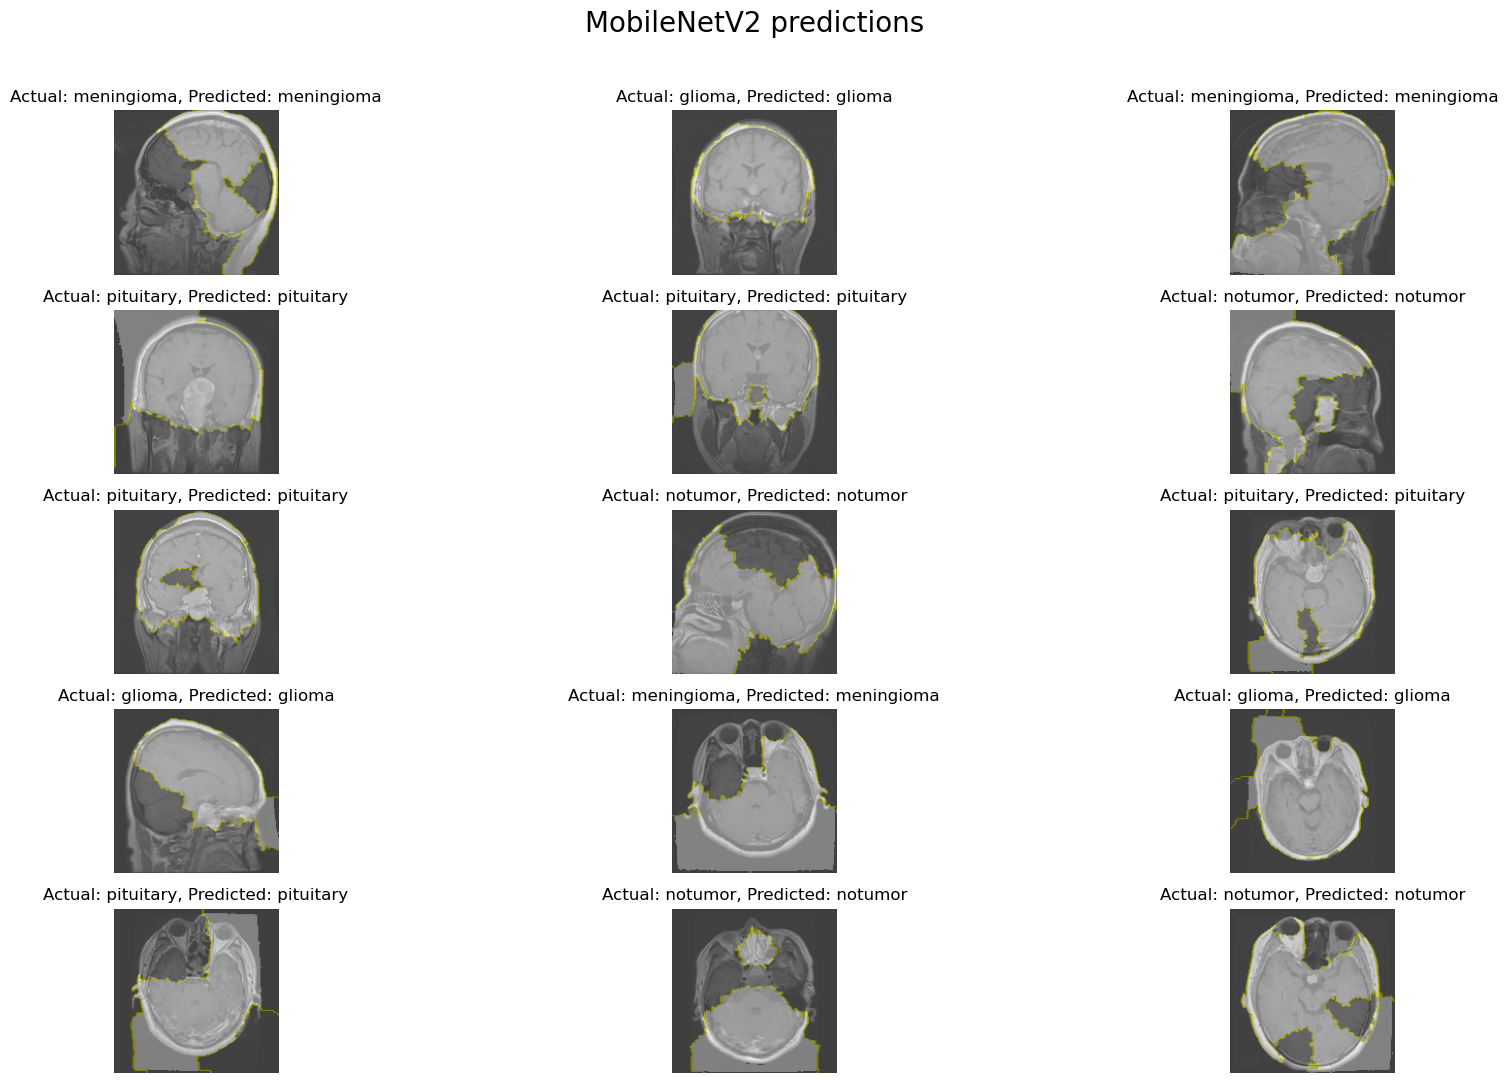

In [79]:
def MobileNetV2_predict_fn(images):
    return best_MobileNetV2_model.predict(images)

plt.figure(figsize=(20, 11))
plt.suptitle("MobileNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(images, actual_classes, MobileNetV2_predicted_classes)):
    # Explain a prediction
    explanation = explainer.explain_instance(image, MobileNetV2_predict_fn, top_labels=4, num_samples=300)

    # Get the mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.subplot(5, 3, i + 1)
    
    plt.imshow(image, alpha=1.0)
    
    # Overlay the LIME explanation
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()